
## Project Name:  Computational Prediction of Treatment Outcome by Machine Learning

### Predicating High-Risk Prostate Cancer from a set of test results (Without doing biopsy)


## Read Data

#### Initialize global variables

In [1]:
Random_State_Split=1
Random_State_Ada=44
Random_State_Sampling=1
Random_State_Imputing=41
Random_State_RF=44
Random_State_Ada_DT=0


### Import libraries

In [2]:

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
#from ipywidgets import interact, widgets
from matplotlib import animation
import keras
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score


Using TensorFlow backend.


### Custom functions for displaying and comparing results

In [3]:
C1=0 #Cost for TN
C2=1 ##Cost for FP
C3=100 ##Cost for FN
C4=-1 #Cost for TP

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
accuracy_table = pd.DataFrame(columns=['Model', 'Accuracy','Sensitivity','Specificity','Precision', 'Recall',
                                       'F1-Sore','AUC','Cost'])

def Add_Update_df(df, accuracy, sensitivity,specificity,precision, recall,f1,auc,cost, algorithm):
    df_new=pd.DataFrame()
    
    if len(df) == 0:
        df_new = df_new.append({'Model':algorithm,
                                        'Accuracy':accuracy, 
                                        'Sensitivity':sensitivity, 
                                        'Specificity':specificity,
                                        'Precision':precision, 
                                        'Recall':recall, 
                                        'F1-Sore':f1,
                                        'AUC':auc,
                                        'Cost':cost
                                            
                                        
                                          }, ignore_index=True)
    else:
    
        for index, row in df.iterrows():
    
            if row['Model'] != algorithm:
                df_new=df_new.append(row)
            elif row['Model'] == algorithm:
                row['Model']=algorithm
                row['Accuracy']=accuracy
                row['Sensitivity']=sensitivity
                row['Specificity']=specificity
                row['Precision']=precision                                 
                row['Recall'] = recall                           
                row['F1'] =f1                             
                df_new=df_new.append(row)    
        
           
    return df_new   
    

def get_accuracy_table(accuracy_table, y_tests, y_pred, algorithm):
    
    fper, tper, thresholds = roc_curve(y_tests, y_pred)
    
    auc = roc_auc_score(y_tests, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_tests, y_pred).ravel()
    cost = tp*C4 + tn*C1 + fp*C2 + fn*C3
    
    accuracy=(tp + tn)/(tn + fp + fn + tp)
    
    sensitivity = tp / (tp + fn)
    
    specificity = tn / (tn+fp)
    precision=tp/(tp+fp)
    recall= tp / (tp + fn)
    f1=(2*(precision*recall))/(precision + recall)
    
    cost = tp*(-1) + tn * 0 + fp*1 + fn*100
    
    
    accuracy_table = accuracy_table.append({'Model':algorithm,
                                        'Accuracy':accuracy, 
                                        'Sensitivity':sensitivity, 
                                        'Specificity':specificity,
                                        'Precision':precision, 
                                        'Recall':recall, 
                                        'F1-Sore':f1,
                                        'AUC': auc,
                                         'Cost': cost
                                                                                    
                                          }, ignore_index=True)
   
    
    #accuracy_table = Add_Update_df(accuracy_table, accuracy, sensitivity, specificity, precision, recall, f1, algorithm)
    
    return accuracy_table

def color_conf_mat(cm,algorithm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.cool)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix-' + algorithm)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), horizontalalignment='center')
    plt.show()
    


In [4]:
def plot_all_roc(result_table, sampling):
    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(result_table.loc[i]['classifiers'], result_table.loc[i]['auc']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)
    
    title1='ROC - Predicting High-Risk Cancer using ' + sampling + " No PSA_Recent_2"
    plt.title(title1, fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

In [5]:
#!pip install fancyimpute
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

def get_confusion_matrix(prediction, actual):
    conf_matrix = pd.DataFrame(list(zip(prediction,actual)), 
                                    columns=['predicted labels','actual labels'])
    conf_matrix['const'] = 1
    conf_matrix = pd.pivot_table(data=conf_matrix, 
                               index='actual labels', 
                               columns='predicted labels', 
                               values='const', 
                               aggfunc=sum)
    conf_matrix = conf_matrix.fillna(0)
    return conf_matrix
  
def heatmap_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8,6))
    g = sns.heatmap(conf_matrix, cbar_kws={'label':'Frequency'}, center=0, cmap=sns.diverging_palette(10, 5, as_cmap=True)).set_title('Confusion Matrix')
    return g
def plot_roc_curve(fper, tper, algorithm):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve-' + algorithm)
    plt.legend()
    plt.show()
    
def roc_curve_sen_spec(y_tests, y_pred, algorithm):
    
    fper, tper, thresholds = roc_curve(y_tests, y_pred) 
    plot_roc_curve(fper, tper, algorithm)


    tn, fp, fn, tp = confusion_matrix(y_tests, y_pred).ravel()
    
    accuracy=(tp + tn)/(tn + fp + fn + tp)
    print('Accuracy:', accuracy)
    sensitivity = tp / (tp + fn)
    print('sensitivity:', sensitivity)

    specificity = tn / (tn+fp)
    print('specificity:', specificity)
    
    print(confusion_matrix(y_tests, y_pred))
    print(classification_report(y_tests,y_pred))



## Show raw data

In [7]:
import pandas as pd
df = pd.read_csv('Data/Prostate_cancer.csv')
lst_all_columns=list(df.columns.values)
#print('\n'.join(df.columns))
print("Total Raw data: ", len(df))
df.head()

Total Raw data:  76682


,dcf_dthp,f_dthp,reasfollp,reassympp,reassurvp,reasothp,hasdep0,hasdep1,hasdep2,hasdep3,...,age,agelevel,dual,has_nrf,nrf_reason,nrf_days,eligible_bq,eligible_sqx,eligible_dqx,eligible_dhq
0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,67.0,2.0,1.0,0.0,NaN,NaN,1.0,1.0,0.0,1.0
1,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,62.0,1.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,1.0
2,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,62.0,1.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,1.0
3,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,57.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0
4,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,...,56.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,1.0


## Filter data

### Filter out patients using Randomize Intervention arm

In [120]:

df=df.loc[(df['arm'] == 1)]
print("Men with Randomize Intervention arm:",len(df))

Men with Randomize Intervention arm: 38340


### Filter out patients using Age (Age between 50 and 75 exclussive are taken for this model)

In [121]:
## Age between between 50 and 75 exclussive are taken for this model
df_new=df.copy()
#print(len(df))
df_new=df.loc[(df['bq_cohort_entryage'] > 50) & (df['bq_cohort_entryage'] < 75)]                                                
                                                   
print("Men Age between 50 and 75 exclusive:",len(df_new))

Men Age between 50 and 75 exclusive: 37415


### Filter out patients with less than 4 PSA results. We saved that filtered data to csv file(psa4_new.csv) to save next run

In [122]:
'''
df_psa4=pd.DataFrame()
for index, row in df.iterrows():
    # access data using column names
    #print(index, row['age'], row['psa_level5'], row['is_dead'])
    num_nan_psa=0
    if (np.isnan(row['psa_level0'])):
           num_nan_psa +=1
    if (np.isnan(row['psa_level1'])):
           num_nan_psa +=1
    if (np.isnan(row['psa_level2'])):
           num_nan_psa +=1
    if (np.isnan(row['psa_level3'])):
           num_nan_psa +=1
    if (np.isnan(row['psa_level4'])):
           num_nan_psa +=1
    if (np.isnan(row['psa_level5'])):
           num_nan_psa +=1
    #print(num_nan_psa)     
    if num_nan_psa<=2:
        df_psa4=df_psa4.append(row)
        num_nan_psa=0
    else:
        num_nan_psa=0
    
    #print(row['psa_level0'])
len(df_psa4), num_nan_psa
'''

"\ndf_psa4=pd.DataFrame()\nfor index, row in df.iterrows():\n    # access data using column names\n    #print(index, row['age'], row['psa_level5'], row['is_dead'])\n    num_nan_psa=0\n    if (np.isnan(row['psa_level0'])):\n           num_nan_psa +=1\n    if (np.isnan(row['psa_level1'])):\n           num_nan_psa +=1\n    if (np.isnan(row['psa_level2'])):\n           num_nan_psa +=1\n    if (np.isnan(row['psa_level3'])):\n           num_nan_psa +=1\n    if (np.isnan(row['psa_level4'])):\n           num_nan_psa +=1\n    if (np.isnan(row['psa_level5'])):\n           num_nan_psa +=1\n    #print(num_nan_psa)     \n    if num_nan_psa<=2:\n        df_psa4=df_psa4.append(row)\n        num_nan_psa=0\n    else:\n        num_nan_psa=0\n    \n    #print(row['psa_level0'])\nlen(df_psa4), num_nan_psa\n"

In [123]:
#df_psa4.to_csv('Data/psa4_new.csv')

In [124]:
df_new=pd.read_csv('Data/psa4_new.csv')
#df_new=pd.read_csv('Data/filtered_masud.csv')
len(df_new)

30362

## Remove all Dead Patients

In [125]:
df_new=df_new[df_new.is_dead==0]
print(len(df_new))
#df_new=df_new[df_new.psa_level5>=4]
print("After Removing dead patients: ",len(df_new))

26295
After Removing dead patients:  26295


## Remove all Except (enlpros_f = 0 or enlpros_f = 1, section 22) BPH (Benign Prostate Hyperplasia)

In [126]:
#df_bph=df_new[((df_new.enlpros_f==0) | (df_new.enlpros_f==1))]
df_bph=df_new[(df_new.enlpros_f>=0)]
#df_bph=df_new[['enlpros_f']]
print(len(df_bph))
df_new=df_bph.copy()

26124


In [127]:
len(df_new)

26124

## Remove Outliers before Imputing (If we want to)

In [128]:
df_new['outliers']=0
df_new['outliers_low']=0
df_new.loc[(df_new.confirmed_pros == 0) & ((df_new.pros_gleason >=8) | (df_new.psa_level5>=20)), 'outliers']=1
#df_new.loc[(df_new.confirmed_pros == 1) & ((df_new.pros_gleason <=3) & (df_new.psa_level5<4)), 'outliers_low']=1
df_new.loc[(df_new.confirmed_pros == 1) & ((df_new.pros_gleason <=3) & (df_new.psa_level5<4)), 'outliers_low']=1
df_new=df_new[df_new.outliers==0]
df_new=df_new[df_new.outliers_low==0]
len(df_new)

26113

In [129]:
'''
df_pros = df[['pros_stage','pros_clinstage']]#.fillna(0)#df['pros_stage']
df_pros=df_pros.fillna(0)
df_pros.head()
'''
df=df_new.copy()
len(df)

26113

### Label “high-risk” for patients with either Gleason Score ≥8, or PSA ≥20

In [130]:
#Filter column manually selecting some features
df_FE=df[['confirmed_pros','intstatp_cat','cstatusp_cat','pros_clinstage','pros_stage','age','pros_gleason','pros_gleason_source','bmi_20','bmi_50','bmi_curr','bmi_curc','psa_days0','psa_days1','psa_days2', 'psa_days3','psa_days4','psa_days5','psa_result0','psa_result1','psa_result2','psa_result3','psa_result4','psa_result5','psa_level0','psa_level1','psa_level1','psa_level2','psa_level3','psa_level4','psa_level5','race7','dre_result3' ]]
df_FE['pros_clinstage']=df_FE['pros_clinstage'].fillna(0)
df_FE['pros_stage']=df_FE['pros_stage'].fillna(0)

df_FE1=((df_FE['pros_gleason']>=8) | (df_FE['psa_level5']>=20))
df_FE2=df_FE[df_FE1]
df_FE.head(10)

C:\Users\syedm\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\syedm\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,confirmed_pros,intstatp_cat,cstatusp_cat,pros_clinstage,pros_stage,age,pros_gleason,pros_gleason_source,bmi_20,bmi_50,...,psa_result5,psa_level0,psa_level1,psa_level1,psa_level2,psa_level3,psa_level4,psa_level5,race7,dre_result3
0,0.0,0.0,0.0,0.0,0.0,67.0,NaN,NaN,26.441992,29.086191,...,1.0,1.57,1.53,1.53,1.41,2.10,2.17,2.63,2.0,1.0
1,0.0,0.0,0.0,0.0,0.0,62.0,NaN,NaN,22.362130,27.952663,...,1.0,0.73,0.44,0.44,0.80,0.45,0.82,0.55,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,57.0,NaN,NaN,18.833955,24.170242,...,1.0,1.87,1.72,1.72,2.65,2.50,1.77,2.69,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,56.0,NaN,NaN,26.600239,28.038089,...,1.0,1.54,1.35,1.35,2.33,1.11,1.25,1.43,1.0,2.0
4,1.0,3.0,1.0,2.0,2.0,56.0,6.0,2.0,25.897018,29.596592,...,8.0,3.88,2.27,2.27,2.65,2.81,NaN,NaN,1.0,1.0
6,1.0,5.0,1.0,2.0,2.0,56.0,6.0,2.0,23.542444,26.681436,...,2.0,1.48,1.52,1.52,2.24,2.88,2.82,4.45,2.0,1.0
7,0.0,0.0,0.0,0.0,0.0,61.0,NaN,NaN,27.181592,30.579291,...,1.0,3.03,2.08,2.08,2.14,2.14,2.05,2.52,2.0,1.0
8,0.0,0.0,0.0,0.0,0.0,56.0,NaN,NaN,22.855110,28.949806,...,1.0,1.21,0.90,0.90,1.11,1.14,1.53,1.73,1.0,3.0
9,0.0,0.0,0.0,0.0,0.0,62.0,NaN,NaN,20.848836,20.848836,...,1.0,2.17,0.81,0.81,0.90,1.04,1.19,0.94,1.0,3.0
10,0.0,0.0,0.0,0.0,0.0,66.0,NaN,NaN,24.443463,28.757015,...,1.0,0.53,0.43,0.43,0.54,0.46,0.46,0.52,1.0,1.0


## Impute NaN Values

In [131]:
df_FE.head()
    

,confirmed_pros,intstatp_cat,cstatusp_cat,pros_clinstage,pros_stage,age,pros_gleason,pros_gleason_source,bmi_20,bmi_50,...,psa_result5,psa_level0,psa_level1,psa_level1,psa_level2,psa_level3,psa_level4,psa_level5,race7,dre_result3
0,0.0,0.0,0.0,0.0,0.0,67.0,NaN,NaN,26.441992,29.086191,...,1.0,1.57,1.53,1.53,1.41,2.10,2.17,2.63,2.0,1.0
1,0.0,0.0,0.0,0.0,0.0,62.0,NaN,NaN,22.362130,27.952663,...,1.0,0.73,0.44,0.44,0.80,0.45,0.82,0.55,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,57.0,NaN,NaN,18.833955,24.170242,...,1.0,1.87,1.72,1.72,2.65,2.50,1.77,2.69,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,56.0,NaN,NaN,26.600239,28.038089,...,1.0,1.54,1.35,1.35,2.33,1.11,1.25,1.43,1.0,2.0
4,1.0,3.0,1.0,2.0,2.0,56.0,6.0,2.0,25.897018,29.596592,...,8.0,3.88,2.27,2.27,2.65,2.81,NaN,NaN,1.0,1.0


### Impute using Iterative Imputer (KNN, DT,  ET)

#### Please uncomment the code block to run Impute and choose different impute method 

In [132]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

data=df_FE#[['age','bmi_20','bmi_50']]

#estimator1=ExtraTreesRegressor(n_estimators=10, random_state=Random_State_Imputing),
estimator_knn= KNeighborsRegressor(n_neighbors=5)
estimator_extra_tree=ExtraTreesRegressor(n_estimators=10, random_state=Random_State_Imputing) #
estimator_dtree=DecisionTreeRegressor(max_features='sqrt', random_state=Random_State_Imputing)
#ExtraTreesRegressor(n_estimators=10, random_state=0),
   

imp = IterativeImputer(estimator=estimator_extra_tree, missing_values=np.nan, sample_posterior=False, 
                                 max_iter=10, tol=0.001, 
                                 n_nearest_features=10, initial_strategy='median')
imp.fit(data)

imputed_data = pd.DataFrame(data=imp.transform(data), 
                             columns=['confirmed_pros','cstatusp_cat','intstatp_cat','pros_clinstage','pros_stage','age','pros_gleason','pros_gleason_source','bmi_20','bmi_50','bmi_curr','bmi_curc','psa_days0','psa_days1','psa_days2', 'psa_days3','psa_days4','psa_days5','psa_result0','psa_result1','psa_result2','psa_result3','psa_result4','psa_result5','psa_level0','psa_level1','psa_level1','psa_level2','psa_level3','psa_level4','psa_level5','race7','dre_result3'],
                             dtype='float')
imputed_data

df_new=imputed_data




C:\Users\syedm\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\impute\_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [133]:
#imputed_data.head()

#### Please uncomment the first line if you run the Impute to save the imputed data frame in csv file

In [9]:
#df_new.to_csv('Data/Imputed_extra_tree.csv')
df_new=pd.read_csv('Data/Imputed_extra_tree.csv')

df_new.head()

,Unnamed: 0,confirmed_pros,cstatusp_cat,intstatp_cat,pros_clinstage,pros_stage,age,pros_gleason,pros_gleason_source,bmi_20,...,psa_level4,psa_level5,race7,dre_result3,PSA_chg_rate,PSA_Level_Change,PSA_Recent_Change,PSA_Recent_2,BMI_chg_rate,High_Risk_Cancer
0,0,0.0,0.0,0.0,0.0,0.0,67.0,4.8,1.9,26.441992,...,2.170,2.630,2.0,1.0,0.000000,0.000594,0.001233,0.001066,25.780942,0
1,1,0.0,0.0,0.0,0.0,0.0,62.0,4.1,1.9,22.362130,...,0.820,0.550,1.0,1.0,0.000000,-0.000101,-0.000769,-0.000225,25.716450,0
2,2,0.0,0.0,0.0,0.0,0.0,57.0,4.9,1.3,18.833955,...,1.770,2.690,1.0,1.0,0.000000,0.000461,0.002682,0.000039,23.542444,0
3,3,0.0,0.0,0.0,0.0,0.0,56.0,4.9,1.9,26.600239,...,1.250,1.430,1.0,2.0,0.000000,-0.000061,0.000484,-0.000827,32.064072,0
4,4,1.0,3.0,1.0,2.0,2.0,56.0,6.0,2.0,25.897018,...,4.007,3.957,1.0,1.0,0.003809,0.000042,-0.000128,0.001087,31.076421,0


## Calculate Rate of PSA-Change

In [10]:
#Calculate rate of change of PSA
PSA_chg_rate = [ (row.psa_result5 - row.psa_result0)/((row.psa_days5 - row.psa_days0) + 0.000001) for index, row in df_new.iterrows() ]
df_new['PSA_chg_rate'] = PSA_chg_rate
PSA_Level_Change = [ (row.psa_level5 - row.psa_level0)/((row.psa_days5 - row.psa_days0) + 0.000001) for index, row in df_new.iterrows() ]
df_new['PSA_Level_Change'] = PSA_Level_Change

PSA_Recent_Change = [ (row.psa_level5 - row.psa_level4)/((row.psa_days5 - row.psa_days4) + 0.000001) for index, row in df_new.iterrows() ]
df_new['PSA_Recent_Change'] = PSA_Recent_Change

PSA_Recent_2 = [ (row.psa_level5 - row.psa_level2)/((row.psa_days5 - row.psa_days2) + 0.000001) for index, row in df_new.iterrows() ]
df_new['PSA_Recent_2'] = PSA_Recent_2

BMI_chg_rate = [ (row.bmi_50 - row.bmi_20)/(30 + 0.000001) for index, row in df_new.iterrows() ]

#df_new['BMI_chg_rate'] = df_new['bmi_curc']#BMI_chg_rate

df_new['BMI_chg_rate'] = df_new['bmi_curr']#BMI_chg_rate

In [11]:
df_new.head()

,Unnamed: 0,confirmed_pros,cstatusp_cat,intstatp_cat,pros_clinstage,pros_stage,age,pros_gleason,pros_gleason_source,bmi_20,...,psa_level4,psa_level5,race7,dre_result3,PSA_chg_rate,PSA_Level_Change,PSA_Recent_Change,PSA_Recent_2,BMI_chg_rate,High_Risk_Cancer
0,0,0.0,0.0,0.0,0.0,0.0,67.0,4.8,1.9,26.441992,...,2.170,2.630,2.0,1.0,0.000000,0.000594,0.001233,0.001066,25.780942,0
1,1,0.0,0.0,0.0,0.0,0.0,62.0,4.1,1.9,22.362130,...,0.820,0.550,1.0,1.0,0.000000,-0.000101,-0.000769,-0.000225,25.716450,0
2,2,0.0,0.0,0.0,0.0,0.0,57.0,4.9,1.3,18.833955,...,1.770,2.690,1.0,1.0,0.000000,0.000461,0.002682,0.000039,23.542444,0
3,3,0.0,0.0,0.0,0.0,0.0,56.0,4.9,1.9,26.600239,...,1.250,1.430,1.0,2.0,0.000000,-0.000061,0.000484,-0.000827,32.064072,0
4,4,1.0,3.0,1.0,2.0,2.0,56.0,6.0,2.0,25.897018,...,4.007,3.957,1.0,1.0,0.003809,0.000042,-0.000128,0.001087,31.076421,0


## Check Data Statistics

In [12]:
#seperate No cancer
df_filtered = df_new[df_new.confirmed_pros == 1] #& ((df_new[df_new.pros_gleason >=8]) | (df_new[df_new.psa_level5>=20]))
print(len(df_filtered))

f1 = df_new[df_new.pros_gleason >=8] #((df_new[df_new.pros_gleason >=8]) | (df_new[df_new.psa_level5>=20]))
f2 = df_new[df_new.psa_level5>=20]
f3 =  df_new[(df_new.confirmed_pros == 1) & ((df_new.pros_gleason >=8) | (df_new.psa_level5>=20))]
f4 =  df_new[((df_new.pros_clinstage>=1) & (df_new.pros_clinstage<=5)) & ((df_new.pros_gleason >=8) | (df_new.psa_level5>=20))]
f5 =  df_new[(df_new.confirmed_pros == 0) & ((df_new.pros_gleason >=8) | (df_new.psa_level5>=20))]
f6=df_new[(df_new.confirmed_pros == 1) & ((df_new.pros_gleason <=3) & (df_new.psa_level5<4))]
print('Gleason Score >=8:',len(f1))
print('PSA level5 >=20:',len(f2))
print('Gleason Score >=8 or PSA level5 >=20 AND Confirmed_Pros=1',len(f3))
print('Gleason Score >=8 or PSA level5 >=20 AND Confirmed_Pros=0',len(f5))
print('Gleason Score <=3 or PSA level5<4 AND Confirmed_Pros=1',len(f6))
print(len(f4))

df_filtered1 = df_new[df_new.cstatusp_cat == 1]
len(df_filtered1)

2310
Gleason Score >=8: 262
PSA level5 >=20: 21
Gleason Score >=8 or PSA level5 >=20 AND Confirmed_Pros=1 280
Gleason Score >=8 or PSA level5 >=20 AND Confirmed_Pros=0 0
Gleason Score <=3 or PSA level5<4 AND Confirmed_Pros=1 0
280


0

In [13]:
f5[['pros_gleason','psa_level5','psa_level3', 'psa_level2']]

,pros_gleason,psa_level5,psa_level3,psa_level2


In [14]:
print(len(df_new), len(df_filtered))
df_new_copy=df_new.copy()
len(df_new_copy)
df_new1 = df_new[(df_new.confirmed_pros != 0) & ((df_new.pros_gleason >7) | (df_new.psa_level5>=20))]

len(df_new1)

26113 2310


280

## Remove Outliers for Positive and Negative Class (If we want to)

## Change label to High-risk or Not

In [15]:
#df_new=df_filtered
# change label to High-Risk or Not from Cancer or Not
df_new['High_Risk_Cancer']=0

df_new.loc[(((df_new.pros_gleason > 7) | (df_new.psa_level5>=20)) & df_new.cstatusp_cat==1), 'High_Risk_Cancer'] = 1 

df_new.head()

,Unnamed: 0,confirmed_pros,cstatusp_cat,intstatp_cat,pros_clinstage,pros_stage,age,pros_gleason,pros_gleason_source,bmi_20,...,psa_level4,psa_level5,race7,dre_result3,PSA_chg_rate,PSA_Level_Change,PSA_Recent_Change,PSA_Recent_2,BMI_chg_rate,High_Risk_Cancer
0,0,0.0,0.0,0.0,0.0,0.0,67.0,4.8,1.9,26.441992,...,2.170,2.630,2.0,1.0,0.000000,0.000594,0.001233,0.001066,25.780942,0
1,1,0.0,0.0,0.0,0.0,0.0,62.0,4.1,1.9,22.362130,...,0.820,0.550,1.0,1.0,0.000000,-0.000101,-0.000769,-0.000225,25.716450,0
2,2,0.0,0.0,0.0,0.0,0.0,57.0,4.9,1.3,18.833955,...,1.770,2.690,1.0,1.0,0.000000,0.000461,0.002682,0.000039,23.542444,0
3,3,0.0,0.0,0.0,0.0,0.0,56.0,4.9,1.9,26.600239,...,1.250,1.430,1.0,2.0,0.000000,-0.000061,0.000484,-0.000827,32.064072,0
4,4,1.0,3.0,1.0,2.0,2.0,56.0,6.0,2.0,25.897018,...,4.007,3.957,1.0,1.0,0.003809,0.000042,-0.000128,0.001087,31.076421,0


In [16]:
Is_High_Risk=((df_new['High_Risk_Cancer']==1))
df_highrisk=df_new[Is_High_Risk]
print("Total and high-Risk patients: ", len(df_new), " and :", len(df_highrisk))


Total and high-Risk patients:  26113  and : 280


In [18]:
#df_new=df_highrisk
df_new['PSA_chg_rate']
#df2=df_new[['High_Risk_Cancer','age','PSA_Level_Change','PSA_Recent_Change','PSA_Recent_2','BMI_chg_rate','race7']]
df2=df_new[['High_Risk_Cancer','age','PSA_Level_Change','PSA_Recent_Change','BMI_chg_rate','race7']]

df2.head(25),df2.count()
df2.dtypes

High_Risk_Cancer       int64
age                  float64
PSA_Level_Change     float64
PSA_Recent_Change    float64
BMI_chg_rate         float64
race7                float64
dtype: object

## Show Label distribution

In [19]:

print(df2.count())
df2.head(6)

High_Risk_Cancer     26113
age                  26113
PSA_Level_Change     26113
PSA_Recent_Change    26113
BMI_chg_rate         26113
race7                26113
dtype: int64


,High_Risk_Cancer,age,PSA_Level_Change,PSA_Recent_Change,BMI_chg_rate,race7
0,0,67.0,0.000594,0.001233,25.780942,2.0
1,0,62.0,-0.000101,-0.000769,25.716450,1.0
2,0,57.0,0.000461,0.002682,23.542444,1.0
3,0,56.0,-0.000061,0.000484,32.064072,1.0
4,0,56.0,0.000042,-0.000128,31.076421,1.0
5,0,56.0,0.001666,0.004503,26.681436,2.0


### Visualize the distribution of labels using pie chart

C:\Users\Masud\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


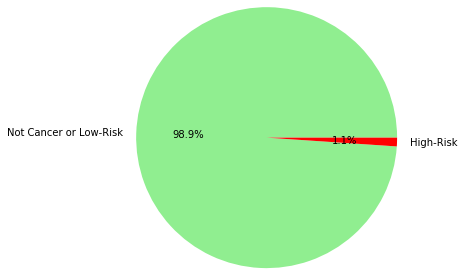

In [20]:
import matplotlib.pyplot as plt
df=df2
df.High_Risk_Cancer=df.High_Risk_Cancer.astype('int64')
sums = df.High_Risk_Cancer.groupby(df.High_Risk_Cancer).count()
plt.axis('equal');
plt.pie(sums,radius=1.5, labels=['Not Cancer or Low-Risk','High-Risk'],autopct='%1.1f%%',colors = ['lightgreen', 'red']);
plt.show()


## Show Correlation

## Select Correlated Features

In [21]:
#show correlation between confirmed_pros and other features
corr_matrix = df.corr()
print(corr_matrix["High_Risk_Cancer"].sort_values(ascending=False))

High_Risk_Cancer     1.000000
PSA_Level_Change     0.194572
PSA_Recent_Change    0.052753
age                  0.042638
race7                0.011300
BMI_chg_rate         0.004387
Name: High_Risk_Cancer, dtype: float64


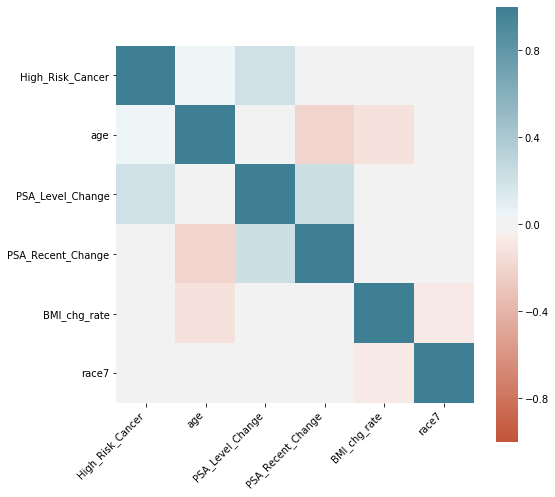

In [146]:
corr = df2.corr()

plt.figure(figsize=(8, 8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=220),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

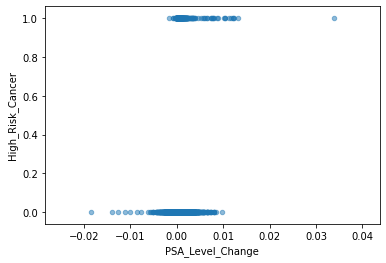

In [147]:
df.plot(kind="scatter", x="PSA_Level_Change", y="High_Risk_Cancer", alpha=0.5)


In [22]:
# Importing MinMaxScaler and initializing it
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
# Scaling down both train and test data set


In [23]:
df_scale=df2.copy()
df3=df2.copy()
df_scale=min_max.fit_transform(df_scale[['PSA_Level_Change', 'PSA_Recent_Change', 'BMI_chg_rate', 'age','race7']])
#df_scale=min_max.fit_transform(df_scale[['PSA_Level_Change', 'PSA_Recent_Change', 'PSA_Recent_2', 'BMI_chg_rate', 'age']])
#df_scale=min_max.fit_transform(df_scale[['PSA_Level_Change', 'PSA_Recent_Change']])
df_scale[:,1]
df3['PSA_Level_Change']=df_scale[:,0]
df3['PSA_Recent_Change']=df_scale[:,1]
#df3['PSA_Recent_2']=df_scale[:,2]

#added later 
df3['BMI_chg_rate']=df_scale[:,2]
df3['age']=df_scale[:,3]
df3['race7']=df_scale[:,4]
df3.head()

,High_Risk_Cancer,age,PSA_Level_Change,PSA_Recent_Change,BMI_chg_rate,race7
0,0,0.692308,0.364222,0.354226,0.240616,0.166667
1,0,0.500000,0.350934,0.346665,0.239169,0.000000
2,0,0.307692,0.361680,0.359696,0.190402,0.000000
3,0,0.269231,0.351697,0.351396,0.381558,0.000000
4,0,0.269231,0.353664,0.349084,0.359403,0.000000


In [24]:
df2=df3.copy()
df2.head()

,High_Risk_Cancer,age,PSA_Level_Change,PSA_Recent_Change,BMI_chg_rate,race7
0,0,0.692308,0.364222,0.354226,0.240616,0.166667
1,0,0.500000,0.350934,0.346665,0.239169,0.000000
2,0,0.307692,0.361680,0.359696,0.190402,0.000000
3,0,0.269231,0.351697,0.351396,0.381558,0.000000
4,0,0.269231,0.353664,0.349084,0.359403,0.000000


## Divide features and Label

In [25]:
df_selected_data=df2[df2.columns[1:len(df2.columns)]]
df_selected_label=df2[df2.columns[0:1]]


In [26]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

df2.High_Risk_Cancer=df2.High_Risk_Cancer.astype('int64')
#print(df_selected.info())

In [27]:
df2.tail(10)

,High_Risk_Cancer,age,PSA_Level_Change,PSA_Recent_Change,BMI_chg_rate,race7
26103,0,0.730769,0.394240,0.359957,0.140805,0.0
26104,0,0.576923,0.346111,0.351372,0.226741,0.0
26105,0,0.961538,0.345088,0.354658,0.190402,0.0
26106,0,0.230769,0.356758,0.346977,0.322570,0.0
26107,0,0.692308,0.356641,0.350733,0.127030,0.5
26108,0,0.730769,0.357168,0.349061,0.255610,0.0
26109,0,0.307692,0.352524,0.344987,0.226622,0.0
26110,0,0.500000,0.359845,0.355340,0.190402,0.5
26111,0,0.230769,0.354362,0.351167,0.333512,0.0
26112,0,0.230769,0.352015,0.345937,0.196130,0.0


## Split train and test Data

In [31]:

from sklearn.model_selection import train_test_split

K=11
Num=5000
df2=df2[:Num]

x_trains, x_tests, y_trains, y_tests=train_test_split(df_selected_data, df_selected_label, test_size=0.3, random_state=Random_State_Split)


In [32]:
#x_trains.info(),y_trains.info()
print(y_trains.info(),y_trains.describe())
yy=y_trains.values.ravel()
yy.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18279 entries, 20309 to 235
Data columns (total 1 columns):
High_Risk_Cancer    18279 non-null int64
dtypes: int64(1)
memory usage: 285.6 KB
None        High_Risk_Cancer
count      18279.000000
mean           0.009847
std            0.098747
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000


(18279,)

## Sampling

In [33]:
print('Before OverSampling, the shape of train_X: {}'.format(x_trains.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format( y_trains.shape))

#from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE,ADASYN, SVMSMOTE, RandomOverSampler,SMOTENC, BorderlineSMOTE,SMOTENC

sm_smote = SMOTE(random_state=Random_State_Sampling, k_neighbors=10)
sm_adasyn = ADASYN(random_state=Random_State_Sampling)
sm_svmsmote=SVMSMOTE(random_state=Random_State_Sampling, k_neighbors=10, n_jobs=1, m_neighbors=20)

sm_RandomOverSampler=RandomOverSampler(random_state=Random_State_Sampling)
#sm_smotenc = SMOTENC(random_state=2)
sm_BorderlineSMOTE = BorderlineSMOTE(random_state=Random_State_Sampling)

sm=sm_smote

X_train_res, y_train_res = sm.fit_sample(x_trains, y_trains)

sum(y_train_res==0)

x_trains=X_train_res
y_trains=y_train_res
y_trains

print('After OverSampling, the shape of train_X: {}'.format(x_trains.shape))
print('After OverSampling, the shape of train_y: {} \n'.format( y_trains.shape))

Before OverSampling, the shape of train_X: (18279, 5)
Before OverSampling, the shape of train_y: (18279, 1) 

After OverSampling, the shape of train_X: (36198, 5)
After OverSampling, the shape of train_y: (36198,) 



C:\Users\Masud\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [157]:
sampling_type=" SMOTE"

## Apply KNN for Classification

In [158]:
N_neighbors=15
neighbors = np.arange(1,N_neighbors)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)

    #Fit the model
    knn.fit(x_trains, y_trains)

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(x_trains, y_trains)

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(x_tests, y_tests.values.ravel()) 


In [159]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_trains, y_trains)

y_pred_knn =knn.predict(x_tests)
print(train_accuracy)


[1.         0.98842286 0.97261826 0.96822502 0.9589412  0.9564821
 0.94899425 0.94589965 0.94070513 0.93871574 0.93343833 0.93244363
 0.92777409 0.92633731]


In [160]:
for i in range(len(train_accuracy)-1):
    train_accuracy[i]=float(str(train_accuracy[i])[:6])
    test_accuracy[i]=float(str(test_accuracy[i])[:6])
#train_accuracy, test_accuracy

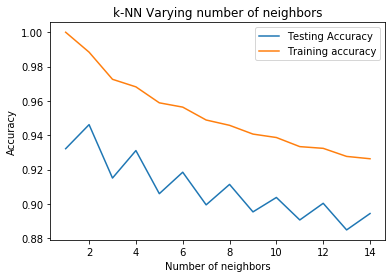

In [161]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()


In [162]:
#print(pred_test)
y_test = y_tests.High_Risk_Cancer #['High_Risk_Cancer']
#print(y_tests)


In [163]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix=get_confusion_matrix(y_pred_knn, y_test)

print(conf_matrix)


predicted labels     0    1
actual labels              
0                 7148  585
1                   80   21


In [164]:
conf_matrix[1][0]

585

## ROC Curve

In [165]:
fpr_knn, tpr_knn, _ = roc_curve(y_tests,  y_pred_knn)
auc_knn = roc_auc_score(y_test, y_pred_knn)
    
result_table = result_table.append({'classifiers':'KNN',
                                        'fpr':fpr_knn, 
                                        'tpr':tpr_knn, 
                                        'auc':auc_knn}, ignore_index=True)

acc_table=get_accuracy_table(accuracy_table, y_tests, y_pred_knn, 'KNN')


In [166]:
accuracy_table
acc_table

,Model,Accuracy,Sensitivity,Specificity,Precision,Recall,F1-Sore,AUC,Cost
0,KNN,0.915114,0.207921,0.92435,0.034653,0.207921,0.059406,0.566135,8564


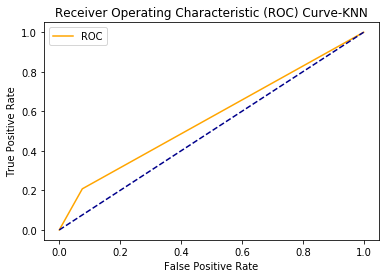

Accuracy: 0.9151136073525657
sensitivity: 0.2079207920792079
specificity: 0.9243501875080823
[[7148  585]
 [  80   21]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      7733
           1       0.03      0.21      0.06       101

    accuracy                           0.92      7834
   macro avg       0.51      0.57      0.51      7834
weighted avg       0.98      0.92      0.94      7834



In [167]:
roc_curve_sen_spec(y_tests, y_pred_knn, 'KNN')

## Logistic Regression

In [168]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=11,  tol=0.00001, C=28, intercept_scaling=1, max_iter=100)
LR.fit(x_trains, y_trains)

y_pred_LR=LR.predict(x_tests)


print(LR.score(x_tests, y_tests))
print(confusion_matrix(y_tests, y_pred_LR))
fpr_lr, tpr_lr, _ = roc_curve(y_tests,  y_pred_LR)
auc_lr = roc_auc_score(y_tests, y_pred_LR)
    
result_table = result_table.append({'classifiers':'LR',
                                        'fpr':fpr_lr, 
                                        'tpr':tpr_lr, 
                                        'auc':auc_lr}, ignore_index=True)

acc_table=get_accuracy_table(acc_table, y_tests, y_pred_LR, 'LR')

acc_table

0.827674240490171
[[6410 1323]
 [  27   74]]


C:\Users\syedm\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Model,Accuracy,Sensitivity,Specificity,Precision,Recall,F1-Sore,AUC,Cost
0,KNN,0.915114,0.207921,0.924350,0.034653,0.207921,0.059406,0.566135,8564
1,LR,0.827674,0.732673,0.828915,0.052971,0.732673,0.098798,0.780794,3949


## Random Forest

In [169]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=15, 
                            oob_score=True, 
                            verbose=1,
                            random_state=Random_State_RF)
rf.fit(x_trains, y_trains)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
C:\Users\syedm\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\syedm\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=True, random_state=44, verbose=1,
                       warm_start=False)

In [170]:
from sklearn.metrics import accuracy_score
y_pred_rf = rf.predict(x_tests)
accuracy = accuracy_score(y_tests, y_pred_rf)
#print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
#print(f'Mean accuracy score: {accuracy:.3}')
accuracy


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


0.9262190451876436

In [171]:
fpr_rf, tpr_rf, _ = roc_curve(y_tests,  y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)
    
result_table = result_table.append({'classifiers':'Random Forest',
                                        'fpr':fpr_rf, 
                                        'tpr':tpr_rf, 
                                        'auc':auc_rf}, ignore_index=True)

acc_table=get_accuracy_table(acc_table, y_tests, y_pred_rf, 'Random Forest')

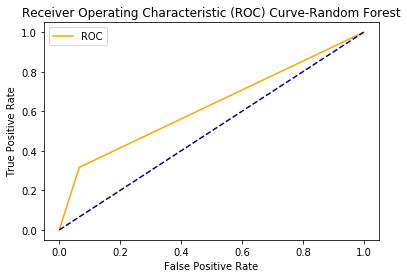

Accuracy: 0.9262190451876436
sensitivity: 0.31683168316831684
specificity: 0.9341781973360921
[[7224  509]
 [  69   32]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      7733
           1       0.06      0.32      0.10       101

    accuracy                           0.93      7834
   macro avg       0.52      0.63      0.53      7834
weighted avg       0.98      0.93      0.95      7834



In [172]:
roc_curve_sen_spec(y_tests, y_pred_rf, 'Random Forest')

## Ada Boost

In [173]:
Random_State_Ada_DT=0
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model_Ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4, random_state=Random_State_Ada_DT),
    n_estimators=150,learning_rate=0.005, random_state=Random_State_Ada
)
'''
#Working ok
model_Ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=150
)
'''
model_Ada.fit(x_trains, y_trains)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=0,
                                

In [174]:
y_pred_ada = model_Ada.predict(x_tests)
accuracy = accuracy_score(y_tests, y_pred_ada)
accuracy

0.750191473066122

In [175]:
fpr_ada, tpr_ada, _ = roc_curve(y_tests,  y_pred_ada)
auc_ada = roc_auc_score(y_test, y_pred_ada)
    
result_table = result_table.append({'classifiers':'AdaBoost',
                                        'fpr':fpr_ada, 
                                        'tpr':tpr_ada, 
                                        'auc':auc_ada}, ignore_index=True)
acc_table=get_accuracy_table(acc_table, y_tests, y_pred_ada, 'AdaBoost')

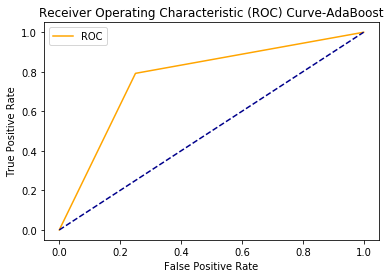

Accuracy: 0.750191473066122
sensitivity: 0.7920792079207921
specificity: 0.7496443812233285
[[5797 1936]
 [  21   80]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      7733
           1       0.04      0.79      0.08       101

    accuracy                           0.75      7834
   macro avg       0.52      0.77      0.47      7834
weighted avg       0.98      0.75      0.85      7834



In [176]:
roc_curve_sen_spec(y_tests, y_pred_ada, 'AdaBoost')

## XGBoost

In [177]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", max_depth=1,
learning_rate= 0.02,
#silent= 1.0,
#eta=0.0001,
n_estimators= 310,                            
random_state=123)

x_trains_xg = x_trains.copy()
x_trains_df=df = pd.DataFrame(
x_trains_xg,
columns=['age','PSA_Level_Change','PSA_Recent_Change','BMI_chg_rate','race7'])
    
#columns=['age','PSA_Level_Change','PSA_Recent_Change','BMI_chg_rate','race7'])

xgb_model.fit(x_trains_df, y_trains)

y_pred_xg = xgb_model.predict(x_tests)

print(confusion_matrix(y_tests, y_pred_xg))

accuracy = accuracy_score(y_tests, y_pred_xg)
print(accuracy)
print(classification_report(y_tests,y_pred_xg))
#y_pred = y_pred[:, 1]  




[[5723 2010]
 [  22   79]]
0.7406178197600204
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      7733
           1       0.04      0.78      0.07       101

    accuracy                           0.74      7834
   macro avg       0.52      0.76      0.46      7834
weighted avg       0.98      0.74      0.84      7834



In [178]:
fpr_xg, tpr_xg, _ = roc_curve(y_tests,  y_pred_xg)
auc_xg = roc_auc_score(y_test, y_pred_xg)

result_table = result_table.append({'classifiers':'XGBoost',
                                        'fpr':fpr_xg, 
                                        'tpr':tpr_xg, 
                                        'auc':auc_xg}, ignore_index=True)
acc_table=get_accuracy_table(acc_table, y_tests, y_pred_xg, 'XGBoost')

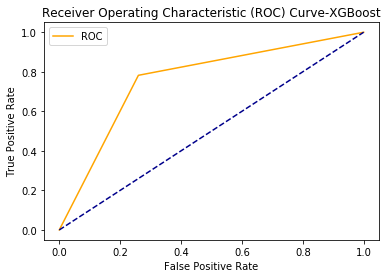

Accuracy: 0.7406178197600204
sensitivity: 0.7821782178217822
specificity: 0.740075003232898
[[5723 2010]
 [  22   79]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      7733
           1       0.04      0.78      0.07       101

    accuracy                           0.74      7834
   macro avg       0.52      0.76      0.46      7834
weighted avg       0.98      0.74      0.84      7834



In [179]:
roc_curve_sen_spec(y_tests, y_pred_xg, 'XGBoost')

## Gradient Boost

In [180]:
#x_trains, x_tests, y_trains, y_tests

from sklearn.ensemble import GradientBoostingClassifier

model_GB = GradientBoostingClassifier(n_estimators=15)
model_GB.fit(x_trains, y_trains)
y_pred_gb = model_GB.predict(x_tests)
target_names = ['0', '1']
print(classification_report(y_tests, y_pred_gb,target_names=target_names))


              precision    recall  f1-score   support

           0       1.00      0.75      0.86      7733
           1       0.04      0.79      0.08       101

    accuracy                           0.75      7834
   macro avg       0.52      0.77      0.47      7834
weighted avg       0.98      0.75      0.85      7834



In [181]:
'''
Evaluation	Value
Sensitivity	0.62
Specificity	0.913
PPV	0.057
NPV	0.996
F1	0.106
'''

'\nEvaluation\tValue\nSensitivity\t0.62\nSpecificity\t0.913\nPPV\t0.057\nNPV\t0.996\nF1\t0.106\n'

In [182]:
print(confusion_matrix(y_tests, y_pred_gb))
target_names = ['0', '1']
print(classification_report(y_tests, y_pred_gb,target_names=target_names))


[[5817 1916]
 [  21   80]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      7733
           1       0.04      0.79      0.08       101

    accuracy                           0.75      7834
   macro avg       0.52      0.77      0.47      7834
weighted avg       0.98      0.75      0.85      7834



In [183]:
fpr_gb, tpr_gb, _ = roc_curve(y_tests,  y_pred_gb)
auc_gb = roc_auc_score(y_test, y_pred_gb)
    
result_table = result_table.append({'classifiers':'Gradient Boost',
                                        'fpr':fpr_gb, 
                                        'tpr':tpr_gb, 
                                        'auc':auc_gb}, ignore_index=True)

acc_table=get_accuracy_table(acc_table, y_tests, y_pred_gb, 'Gradient Boost')


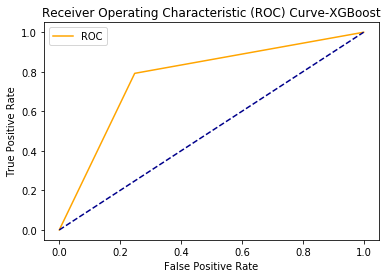

Accuracy: 0.7527444472810825
sensitivity: 0.7920792079207921
specificity: 0.7522306995991207
[[5817 1916]
 [  21   80]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      7733
           1       0.04      0.79      0.08       101

    accuracy                           0.75      7834
   macro avg       0.52      0.77      0.47      7834
weighted avg       0.98      0.75      0.85      7834



In [184]:
roc_curve_sen_spec(y_tests, y_pred_gb, 'Gradient Boost')

In [185]:
acc_table.head()

,Model,Accuracy,Sensitivity,Specificity,Precision,Recall,F1-Sore,AUC,Cost
0,KNN,0.915114,0.207921,0.924350,0.034653,0.207921,0.059406,0.566135,8564
1,LR,0.827674,0.732673,0.828915,0.052971,0.732673,0.098798,0.780794,3949
2,Random Forest,0.926219,0.316832,0.934178,0.059150,0.316832,0.099688,0.625505,7377
3,AdaBoost,0.750191,0.792079,0.749644,0.039683,0.792079,0.075579,0.770862,3956
4,XGBoost,0.740618,0.782178,0.740075,0.037817,0.782178,0.072146,0.761127,4131


In [187]:
def color_conf_mat(cm,algorithm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.cool)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix-' + algorithm)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), horizontalalignment='center')
    plt.show()

In [189]:
print(acc_table.head())

           Model  Accuracy  Sensitivity  Specificity  Precision    Recall  \
0            KNN  0.915114     0.207921     0.924350   0.034653  0.207921   
1             LR  0.827674     0.732673     0.828915   0.052971  0.732673   
2  Random Forest  0.926219     0.316832     0.934178   0.059150  0.316832   
3       AdaBoost  0.750191     0.792079     0.749644   0.039683  0.792079   
4        XGBoost  0.740618     0.782178     0.740075   0.037817  0.782178   

    F1-Sore       AUC  Cost  
0  0.059406  0.566135  8564  
1  0.098798  0.780794  3949  
2  0.099688  0.625505  7377  
3  0.075579  0.770862  3956  
4  0.072146  0.761127  4131  


## Multi-Layer Perceptron (MLP)

#### Take copy of train and test data and labels as we shall make some preprocessing like one-hot encoding for NN

In [190]:

x_trains_copy=x_trains.copy()
y_trains_copy=y_trains.copy()
x_tests_copy=x_tests.copy()
y_tests_copy=y_tests.copy()
y_trains_copy.shape, y_tests_copy.shape



((36192,), (7834, 1))

In [191]:

x_trains=x_trains_copy.copy()
y_trains=y_trains_copy.copy()
x_tests=x_tests_copy.copy()
y_tests=y_tests_copy.copy()
y_trains.shape, y_tests.shape


((36192,), (7834, 1))

In [192]:
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.utils import to_categorical

print(x_trains.shape, x_tests.shape)
#y_trains = to_categorical(y_trains)
y_tests = to_categorical(y_tests)
print(y_tests.shape)

from keras.callbacks import EarlyStopping, ModelCheckpoint 
early_stopping =EarlyStopping(monitor='val_loss', patience=100, mode='auto')  

(36192, 5) (7834, 5)
(7834, 2)


In [193]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import SGD, rmsprop,adam

# Import `Dense` from `keras.layers`
from keras.layers import Dense


y_trains = to_categorical(y_trains)
#y_tests = to_categorical(y_tests)

# Initialize the constructor
model = Sequential()

model.add(BatchNormalization())
# Add an input layer 
model.add(Dense(18, activation='relu', input_shape=(6,)))

model.add(BatchNormalization())
# Add one hidden layer 
#model.add(Dropout(0.5))
model.add(Dense(9, activation='relu'))
#model.add(Dropout(0.4))

model.add(BatchNormalization())
# Add one hidden layer 
#model.add(Dropout(0.5))
model.add(Dense(6, activation='relu'))
#model.add(Dropout(0.4))


model.add(BatchNormalization())
# Add one hidden layer 
#model.add(Dropout(0.5))
model.add(Dense(5, activation='relu'))


#added after we got good model to test for better this layer in oct 3 7pm 
#adding this layer gave 84 and 57 accuracy for 2 class

model.add(BatchNormalization())
# Add one hidden layer 
#model.add(Dropout(0.5))
model.add(Dense(5, activation='relu'))




model.add(BatchNormalization())
# Add one hidden layer 
#model.add(Dropout(0.5))
model.add(Dense(4, activation='relu'))

model.add(BatchNormalization()) # added for test in 3 oct

'''
model.add(BatchNormalization())
# Add one hidden layer 
#model.add(Dropout(0.5))
model.add(Dense(4, activation='relu'))

model.add(BatchNormalization()) # added for test in 5 oct


'''

# Add one hidden layer 
model.add(Dense(3, activation='relu'))

model.add(BatchNormalization()) # added for test in 5 oct

# Add one hidden layer 
model.add(Dense(3, activation='relu'))

#model.add(BatchNormalization()) # added for test in 5 oct

# Add an output layer 
model.add(Dense(2, activation='softmax'))

### Optimize and Compile NN

In [195]:
opt1 = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
opt2 = adam(lr=0.002)
opt3 = rmsprop(lr=0.0017, decay=3e-6)

opt4=keras.optimizers.RMSprop(lr=0.0025, rho=0.9)
opt5=keras.optimizers.RMSprop(lr=0.002, rho=0.8, epsilon=None, decay=1e-5)

adadelta1=keras.optimizers.Adadelta(lr=1.0, rho=0.95)
rmsprop1=keras.optimizers.RMSprop(lr=0.001, rho=0.9)
adam1=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

early_stopping =EarlyStopping(monitor='val_loss', patience=100, mode='auto')  
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('Saved_model/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy',
              optimizer=opt3,
              metrics=['accuracy']
              #, validation_data=(x_tests, y_tests)
             # , callbacks=[early_stopping]
             )
                   




In [196]:
history = model.fit(x_trains, y_trains,epochs=150, batch_size=128, verbose=1
                    , validation_data=(x_tests, y_tests)
                    , callbacks=[es, mc]
                   )

Train on 36192 samples, validate on 7834 samples
Epoch 1/150
36192/36192 [==============================] - 8s 208us/step - loss: 0.5782 - acc: 0.7068 - val_loss: 0.5948 - val_acc: 0.7924

Epoch 00001: val_acc improved from -inf to 0.79244, saving model to Saved_model/best_model.h5
Epoch 2/150
36192/36192 [==============================] - 5s 145us/step - loss: 0.5278 - acc: 0.7509 - val_loss: 0.6381 - val_acc: 0.7082

Epoch 00002: val_acc did not improve from 0.79244
Epoch 3/150
36192/36192 [==============================] - 5s 134us/step - loss: 0.4979 - acc: 0.7745 - val_loss: 0.5676 - val_acc: 0.7257

Epoch 00003: val_acc did not improve from 0.79244
Epoch 4/150
36192/36192 [==============================] - 5s 146us/step - loss: 0.4685 - acc: 0.7888 - val_loss: 0.5187 - val_acc: 0.7207

Epoch 00004: val_acc did not improve from 0.79244
Epoch 5/150
36192/36192 [==============================] - 5s 136us/step - loss: 0.4594 - acc: 0.7931 - val_loss: 0.4419 - val_acc: 0.7705

Epoch 0

In [197]:
#history = model.fit(x_trains, y_trains,epochs=100, batch_size=256, verbose=1)
from keras.models import load_model
saved_model = load_model('Saved_model/best_model.h5')

In [198]:
# evaluate the model
_, train_acc = saved_model.evaluate(x_trains, y_trains, verbose=0)
_, test_acc = saved_model.evaluate(x_tests, y_tests, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.799, Test: 0.838


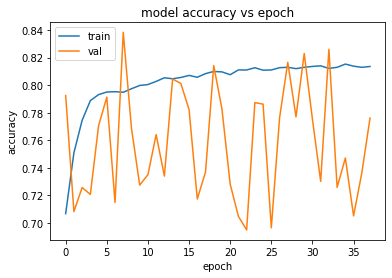

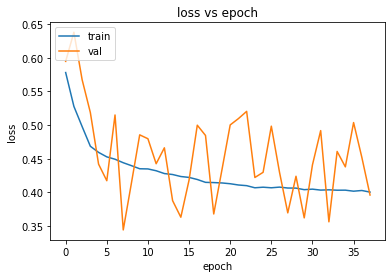

In [199]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model=saved_model

In [200]:
#pl.plot(history.history['val_acc'])
#model=saved_model
x_tests.shape, y_tests.shape

((7834, 5), (7834, 2))

In [201]:
#y_tests = to_categorical(y_tests_copy)
score = model.evaluate(x_tests, y_tests, batch_size=128)
score

7834/7834 [==============================] - 0s 33us/step


[0.34410086985537675, 0.8383967322234387]

In [202]:
x_trains.shape

(36192, 5)

In [203]:
y_pred_nn = model.predict(x_tests)
#print(confusion_matrix(y_tests, y_pred_nn))
#yy=np.int64(y_pred_nn)

y_pred_nn = np.argmax(y_pred_nn, axis=1)

In [204]:
fpr_nn, tpr_nn, _ = roc_curve(y_tests_copy,  y_pred_nn)
auc_nn = roc_auc_score(y_tests_copy, y_pred_nn)
    
result_table = result_table.append({'classifiers':'NN',
                                        'fpr':fpr_nn, 
                                        'tpr':tpr_nn, 
                                        'auc':auc_nn}, ignore_index=True)

acc_table=get_accuracy_table(acc_table, y_tests_copy, y_pred_nn, 'NN')

acc_table

,Model,Accuracy,Sensitivity,Specificity,Precision,Recall,F1-Sore,AUC,Cost
0,KNN,0.915114,0.207921,0.924350,0.034653,0.207921,0.059406,0.566135,8564
1,LR,0.827674,0.732673,0.828915,0.052971,0.732673,0.098798,0.780794,3949
2,Random Forest,0.926219,0.316832,0.934178,0.059150,0.316832,0.099688,0.625505,7377
3,AdaBoost,0.750191,0.792079,0.749644,0.039683,0.792079,0.075579,0.770862,3956
4,XGBoost,0.740618,0.782178,0.740075,0.037817,0.782178,0.072146,0.761127,4131
5,Gradient Boost,0.752744,0.792079,0.752231,0.040080,0.792079,0.076299,0.772155,3936
6,NN,0.838397,0.693069,0.840295,0.053640,0.693069,0.099573,0.766682,4265


In [205]:
#result_table=result_table.drop([5,6,7,8,9,10])
result_table
#acc_table=acc_table.drop([5,7])
acc_table

,Model,Accuracy,Sensitivity,Specificity,Precision,Recall,F1-Sore,AUC,Cost
0,KNN,0.915114,0.207921,0.924350,0.034653,0.207921,0.059406,0.566135,8564
1,LR,0.827674,0.732673,0.828915,0.052971,0.732673,0.098798,0.780794,3949
2,Random Forest,0.926219,0.316832,0.934178,0.059150,0.316832,0.099688,0.625505,7377
3,AdaBoost,0.750191,0.792079,0.749644,0.039683,0.792079,0.075579,0.770862,3956
4,XGBoost,0.740618,0.782178,0.740075,0.037817,0.782178,0.072146,0.761127,4131
5,Gradient Boost,0.752744,0.792079,0.752231,0.040080,0.792079,0.076299,0.772155,3936
6,NN,0.838397,0.693069,0.840295,0.053640,0.693069,0.099573,0.766682,4265


In [206]:
print(confusion_matrix(y_tests_copy, y_pred_nn))
print(classification_report(y_tests_copy,y_pred_nn,target_names=target_names))

[[6498 1235]
 [  31   70]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      7733
           1       0.05      0.69      0.10       101

    accuracy                           0.84      7834
   macro avg       0.52      0.77      0.51      7834
weighted avg       0.98      0.84      0.90      7834



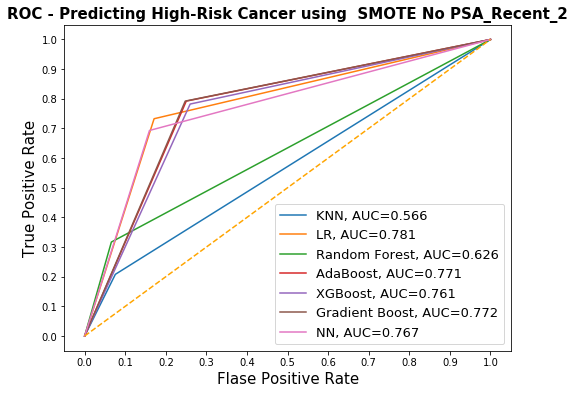

In [207]:
plot_all_roc(result_table, " SMOTE")

In [208]:
acc_table

,Model,Accuracy,Sensitivity,Specificity,Precision,Recall,F1-Sore,AUC,Cost
0,KNN,0.915114,0.207921,0.924350,0.034653,0.207921,0.059406,0.566135,8564
1,LR,0.827674,0.732673,0.828915,0.052971,0.732673,0.098798,0.780794,3949
2,Random Forest,0.926219,0.316832,0.934178,0.059150,0.316832,0.099688,0.625505,7377
3,AdaBoost,0.750191,0.792079,0.749644,0.039683,0.792079,0.075579,0.770862,3956
4,XGBoost,0.740618,0.782178,0.740075,0.037817,0.782178,0.072146,0.761127,4131
5,Gradient Boost,0.752744,0.792079,0.752231,0.040080,0.792079,0.076299,0.772155,3936
6,NN,0.838397,0.693069,0.840295,0.053640,0.693069,0.099573,0.766682,4265


In [209]:
x_trains.shape, y_trains.shape

((36192, 5), (36192, 2))

## Naive Bayes

In [210]:
y_trains=y_trains_copy
x_trains=x_trains_copy
y_tests=y_tests_copy
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB().fit(x_trains, y_trains)

In [211]:
import numpy as np

y_pred_nb = NB.predict(x_tests)


In [212]:
#print(confusion_matrix(y_tests, y_pred_nb))

In [213]:
fpr_nb, tpr_nb, _ = roc_curve(y_tests,  y_pred_nb)
auc_nb = roc_auc_score(y_tests, y_pred_nb)
    
result_table = result_table.append({'classifiers':'NB',
                                        'fpr':fpr_nb, 
                                        'tpr':tpr_nb, 
                                        'auc':auc_nb}, ignore_index=True)

acc_table=get_accuracy_table(acc_table, y_tests, y_pred_nb, 'NB')

acc_table

,Model,Accuracy,Sensitivity,Specificity,Precision,Recall,F1-Sore,AUC,Cost
0,KNN,0.915114,0.207921,0.924350,0.034653,0.207921,0.059406,0.566135,8564
1,LR,0.827674,0.732673,0.828915,0.052971,0.732673,0.098798,0.780794,3949
2,Random Forest,0.926219,0.316832,0.934178,0.059150,0.316832,0.099688,0.625505,7377
3,AdaBoost,0.750191,0.792079,0.749644,0.039683,0.792079,0.075579,0.770862,3956
4,XGBoost,0.740618,0.782178,0.740075,0.037817,0.782178,0.072146,0.761127,4131
5,Gradient Boost,0.752744,0.792079,0.752231,0.040080,0.792079,0.076299,0.772155,3936
6,NN,0.838397,0.693069,0.840295,0.053640,0.693069,0.099573,0.766682,4265
7,NB,0.903625,0.386139,0.910384,0.053279,0.386139,0.093637,0.648261,6854


In [214]:
acc_table['Model']

0               KNN
1                LR
2     Random Forest
3          AdaBoost
4           XGBoost
5    Gradient Boost
6                NN
7                NB
Name: Model, dtype: object

### Visualize color confusion matrix for few models

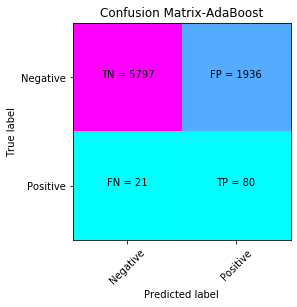

None


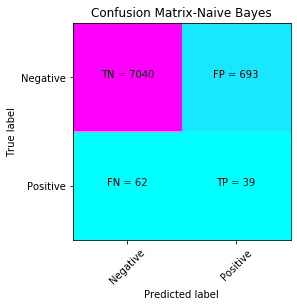

None


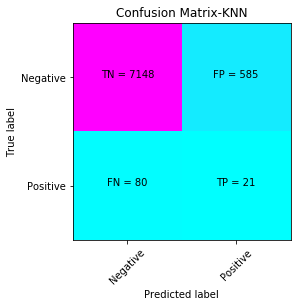

None


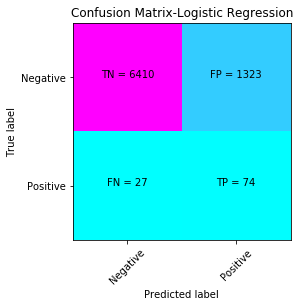

None


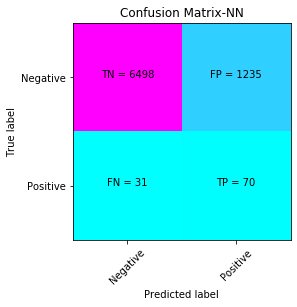

In [215]:
cm_ada=confusion_matrix(y_tests, y_pred_ada)
cm_knn=confusion_matrix(y_tests, y_pred_knn)
cm_nn=confusion_matrix(y_tests, y_pred_nn)
cm_nb=confusion_matrix(y_tests, y_pred_nb)
cm_lr=confusion_matrix(y_tests, y_pred_LR)

print(color_conf_mat(cm_ada, 'AdaBoost'))
print(color_conf_mat(cm_nb, 'Naive Bayes'))

print(color_conf_mat(cm_knn, 'KNN'))
print(color_conf_mat(cm_lr, 'Logistic Regression'))
color_conf_mat(cm_nn, 'NN')

### Classification results using all metrics for all models after applying SMOTE sampling algorithms and removing PSA_Recent_2 Features

In [217]:
acc_table

,Model,Accuracy,Sensitivity,Specificity,Precision,Recall,F1-Sore,AUC,Cost
0,KNN,0.915114,0.207921,0.924350,0.034653,0.207921,0.059406,0.566135,8564
1,LR,0.827674,0.732673,0.828915,0.052971,0.732673,0.098798,0.780794,3949
2,Random Forest,0.926219,0.316832,0.934178,0.059150,0.316832,0.099688,0.625505,7377
3,AdaBoost,0.750191,0.792079,0.749644,0.039683,0.792079,0.075579,0.770862,3956
4,XGBoost,0.740618,0.782178,0.740075,0.037817,0.782178,0.072146,0.761127,4131
5,Gradient Boost,0.752744,0.792079,0.752231,0.040080,0.792079,0.076299,0.772155,3936
6,NN,0.838397,0.693069,0.840295,0.053640,0.693069,0.099573,0.766682,4265
7,NB,0.903625,0.386139,0.910384,0.053279,0.386139,0.093637,0.648261,6854


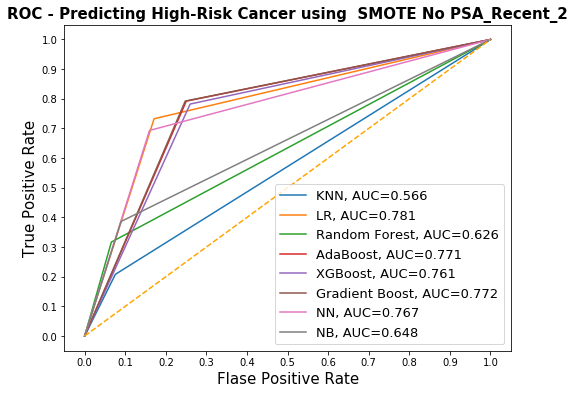

In [218]:
plot_all_roc(result_table, sampling_type)

### ROC curves for models after applying SMOTE sampling algorithms and removing PSA_Recent_2 Features

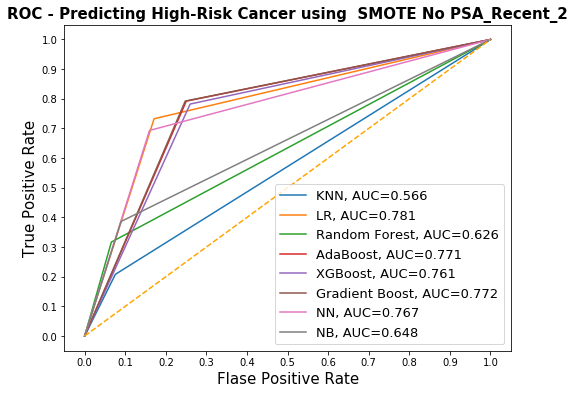

In [219]:
plot_all_roc(result_table, sampling_type)